In [2]:
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np

In [3]:
import ili
from ili.dataloaders import StaticNumpyLoader
from ili.validation.runner import ValidationRunner

In [4]:
# Set up paths
cfgdir = '/home/mattho/git/ltu-ili/paper/configs/xray'
wdir = '/home/mattho/git/ltu-ili/paper/wdir/xray'
imdir = '/home/mattho/git/ltu-ili/paper/images'

os.chdir(wdir)

## Load and preprocess data

In [5]:
# import pickle

# os.chdir('/home/mattho/git/ltu-ili/paper/wdir/xray')
# filename = 'Magneticum_dynXray_z=0.1-0.29_LOS-z_131222_contam.p'
# with open(filename, 'rb') as f:
#     cat = pickle.load(f)

# theta = np.log10(cat.prop['m500c'].values)
# theta = theta.reshape(-1, 1)
# x = np.log10(cat.ximgs+1)
# x = np.swapaxes(x, 1, -1)

# i = 0
# np.random.seed(42)
# mask = np.random.choice(10, len(x), replace=True) == i
# x_train = x[~mask]
# theta_train = theta[~mask]
# x_test = x[mask]
# theta_test = theta[mask]

# np.save('x_train.npy', x_train)
# np.save('theta_train.npy', theta_train)
# np.save('x_test.npy', x_test)
# np.save('theta_test.npy', theta_test)

In [6]:
x, theta = np.load('x_train.npy'), np.load('theta_train.npy')

Text(0.5, 0, '$\\log_{10}(M_{500c}/M_\\odot)$')

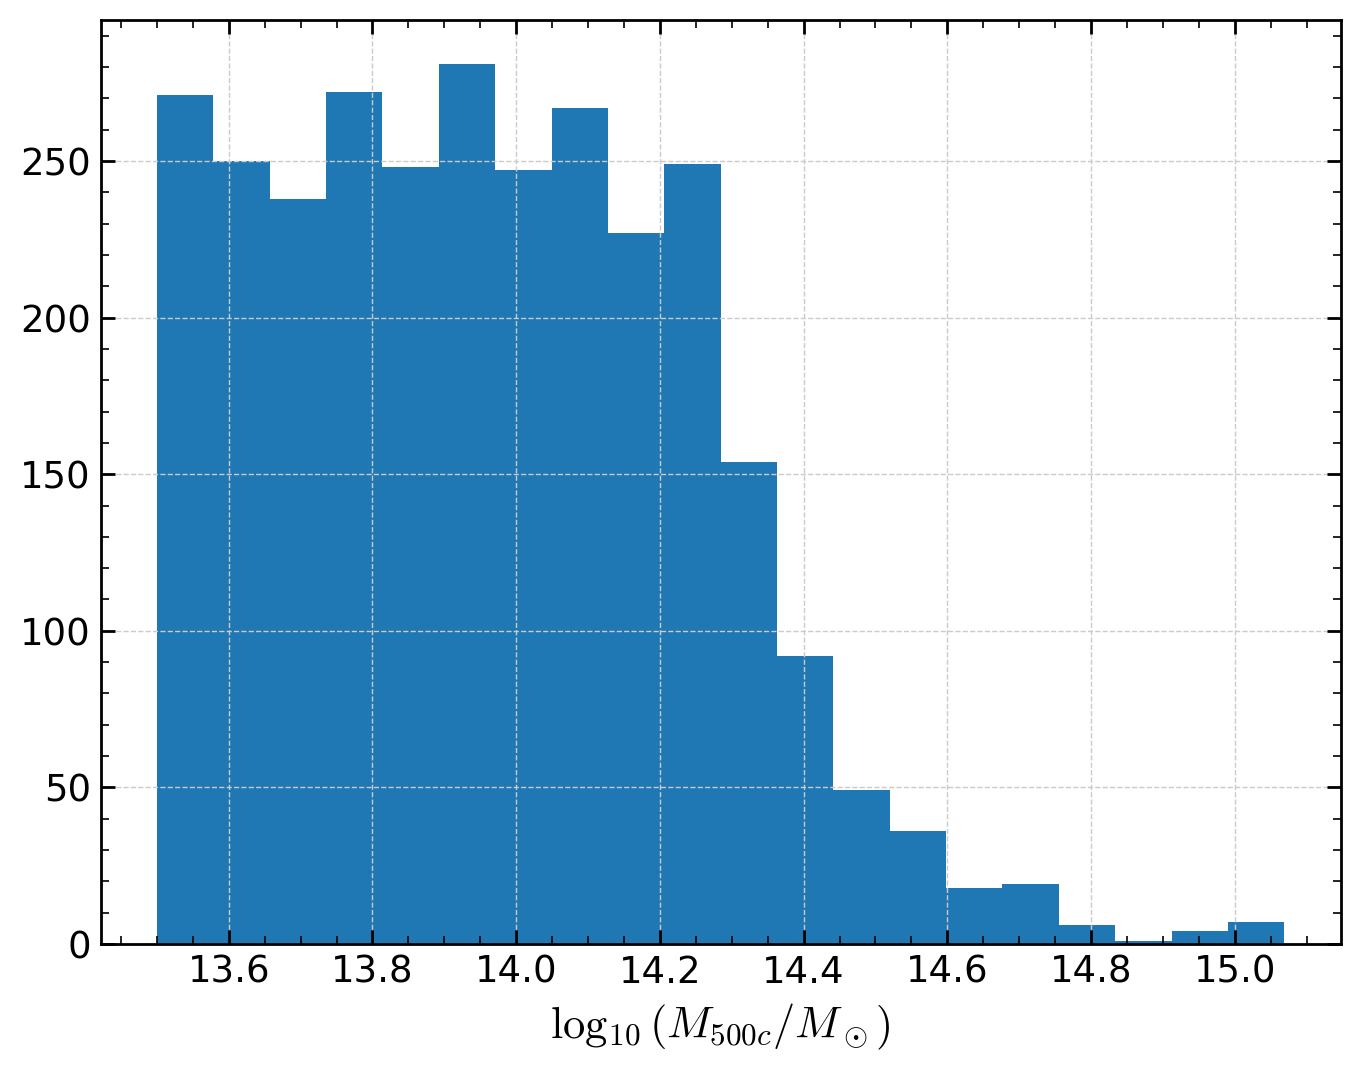

In [7]:
# theta histogram
fig, ax = plt.subplots()
ax.hist(theta, bins=20)
ax.set_xlabel(r'$\log_{10}(M_{500c}/M_\odot)$')

/tmp/ipykernel_363643/3095218823.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, extend='both')


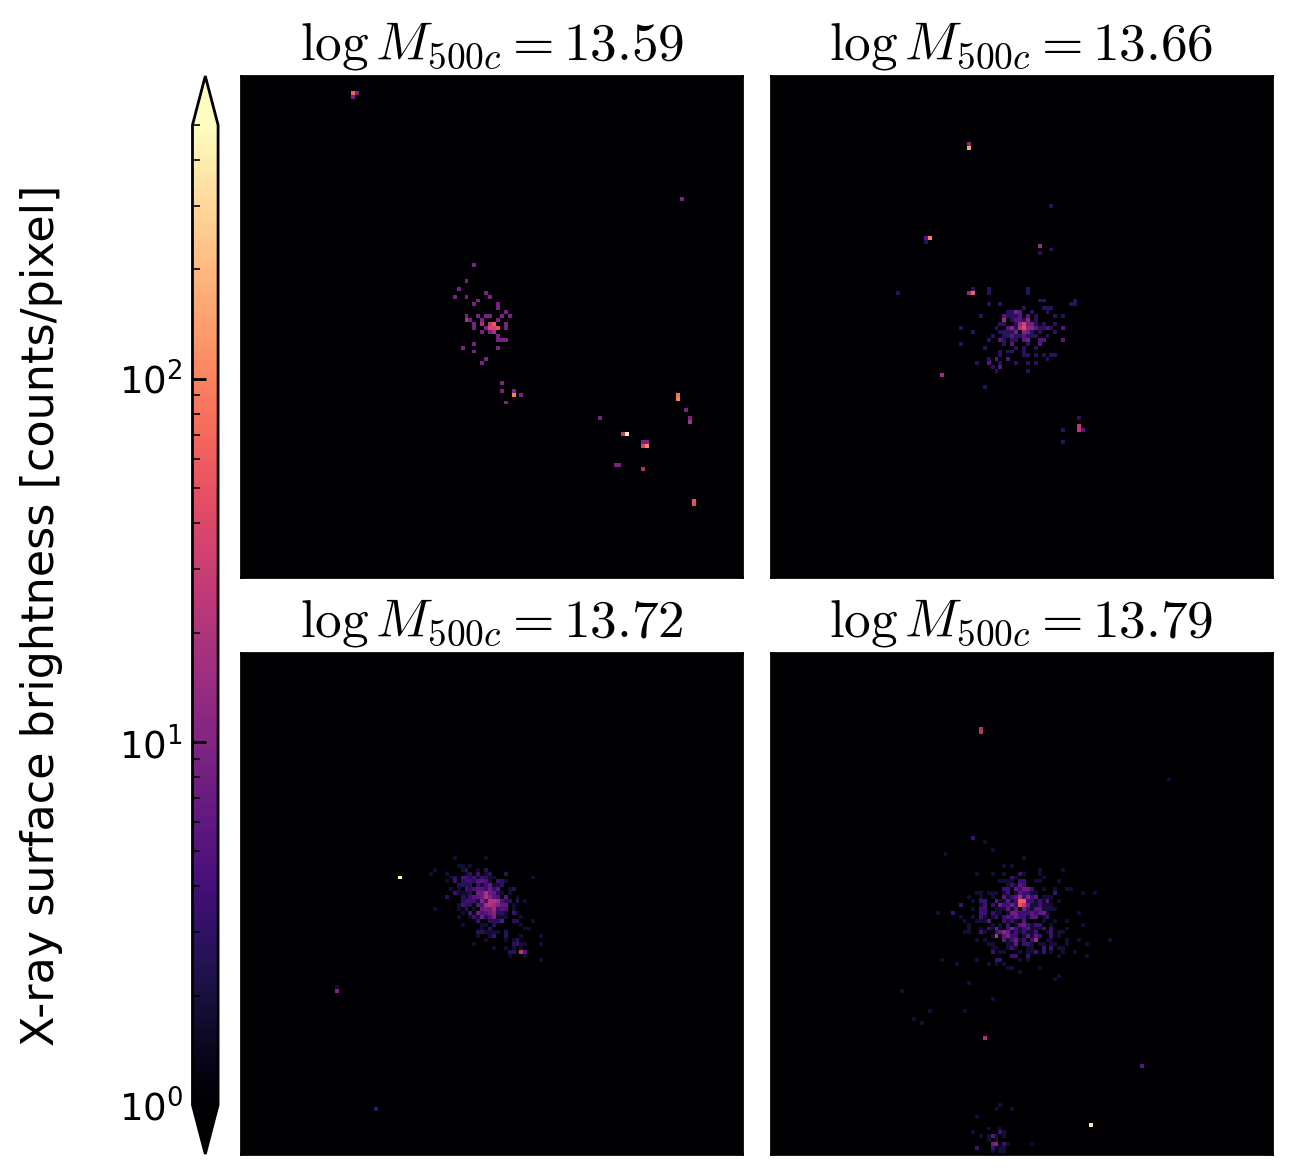

In [8]:
inds = np.random.choice(len(x), 4, replace=False)
inds = sorted(inds, key=lambda x: theta[x])

f = plt.figure(figsize=(7, 7))
gs = mpl.gridspec.GridSpec(
    2, 3, 
    width_ratios=[0.05, 1, 1], height_ratios=[1, 1],
    wspace=0.05, hspace=0.15)

axes = []
for i in range(2):
    for j in range(1,3):
        axes.append(plt.subplot(gs[i, j]))

for i, ax in zip(inds, axes):
    x_ = 10**x[i] - 1
    im = ax.imshow(
        x_.T, cmap='magma', 
        norm=mpl.colors.LogNorm(vmin=1, vmax=500, clip=True))
    ax.set_title(f'$\log M_{{500c}} = {theta[i,0]:.2f}$')
    ax.set_xticks([])
    ax.set_yticks([])

cax = plt.subplot(gs[:, 0])
cbar = plt.colorbar(im, cax=cax, extend='both')
cbar.set_label('X-ray surface brightness [counts/pixel]', 
               rotation=90, labelpad=20)
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
# f.savefig(join(imdir, 'xray_example.pdf'), bbox_inches='tight')

## Load model outputs

In [5]:
x, theta = np.load('x_test.npy'), np.load('theta_test.npy')

samples = np.load(join(wdir, 'xray_SNPE_posterior_samples.npy'))

filename = join(wdir, 'xray_SNPE_summary.json')
summary = pd.read_json(filename)

Text(0, 0.5, 'Log probability')

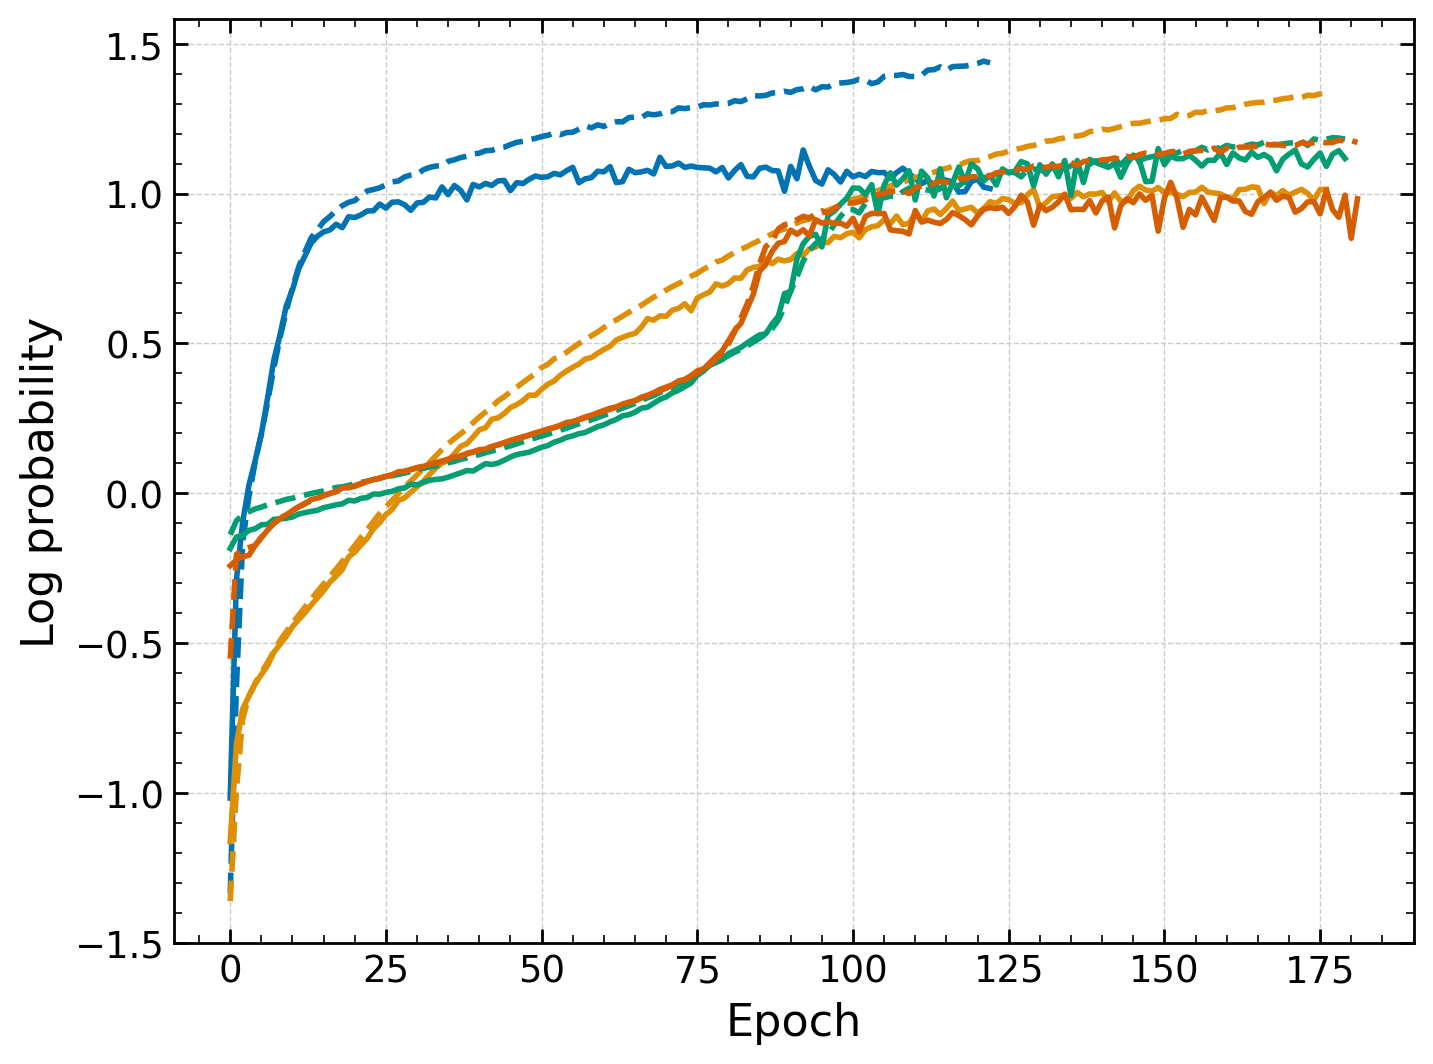

In [6]:
colors = sns.color_palette('colorblind', n_colors=4)
for i in range(len(summary)):
    plt.plot(summary.loc[i, 'training_log_probs'], color=colors[i], ls='--')
    plt.plot(summary.loc[i, 'validation_log_probs'], color=colors[i])

plt.xlabel('Epoch')
plt.ylabel('Log probability')

In [7]:
means = np.mean(samples, axis=0)
np.std(theta-means)

0.07825363718225403

In [8]:
sperc = np.percentile(samples, [16, 50, 84], axis=0)[...,0]

In [28]:
# mask evenly over theta
Nsamp = 80
mbins = np.linspace(theta.min(), theta.max(), 20)
inds = np.digitize(theta, mbins).flatten()

to_plot = []
for i in range(len(mbins)):
    mask = inds == i
    if mask.sum() == 0:
        continue
    to_plot.append(np.random.choice(np.where(mask)[0], Nsamp//20, replace=True))
to_plot = np.concatenate(to_plot)
to_plot.shape

(72,)

(-0.3, 0.3)

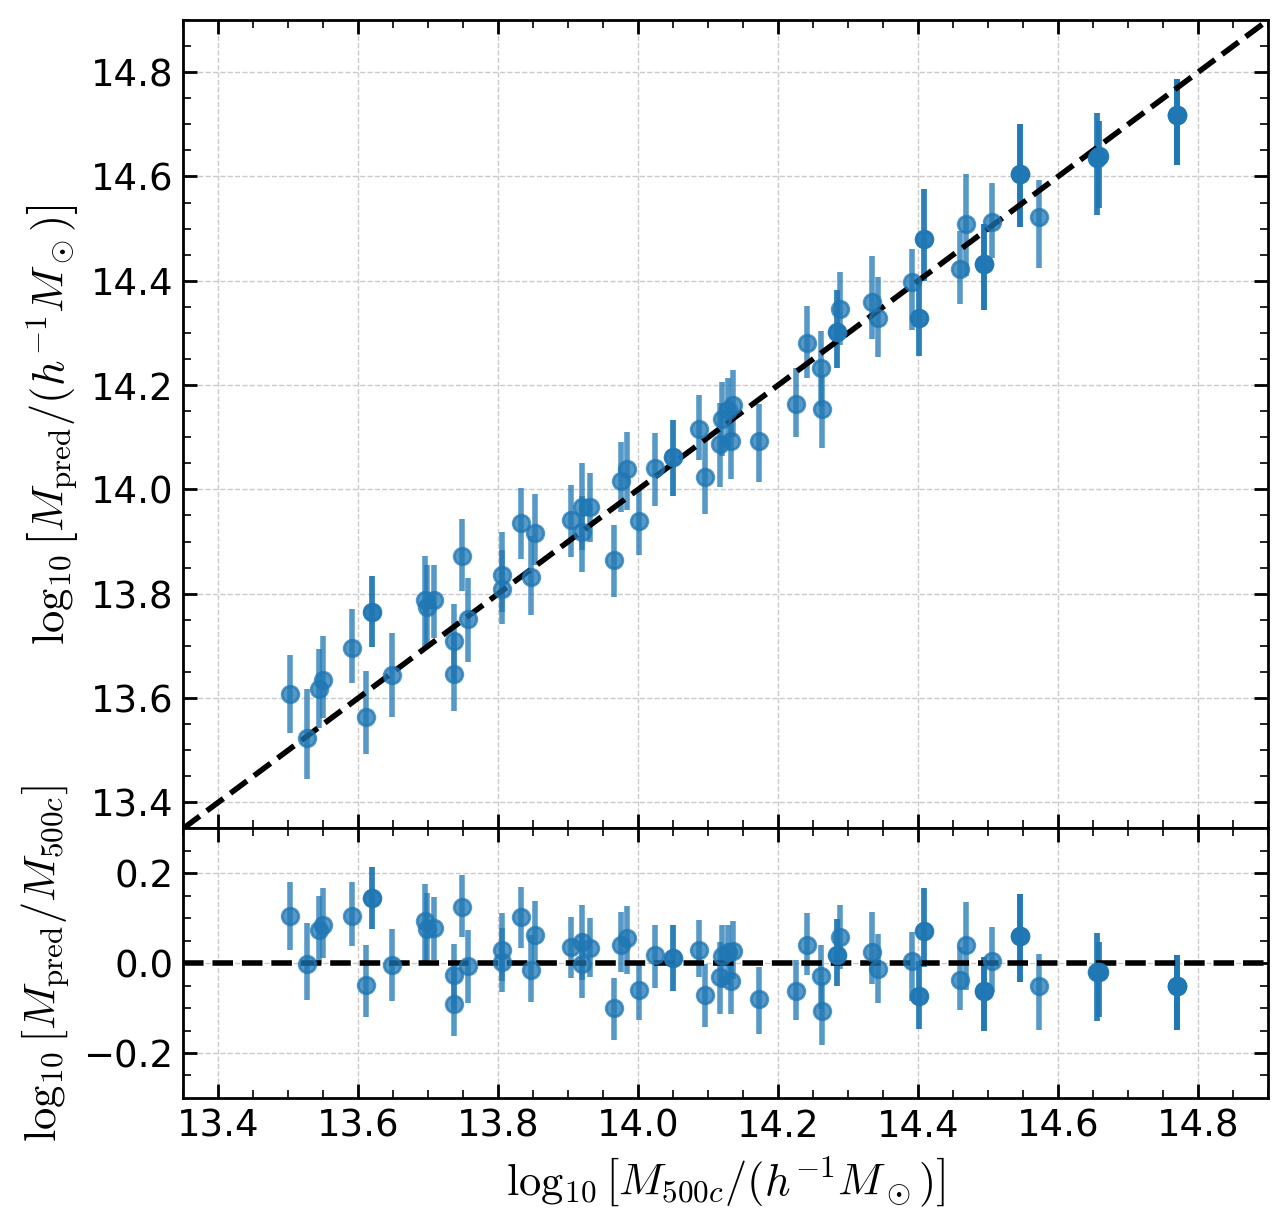

In [29]:
# plot errorbars
f, axs = plt.subplots(2,1, figsize=(7, 7), sharex=True,
                      gridspec_kw={'height_ratios': [3, 1], 'hspace':0})
ax = axs[0]
ax.errorbar(
    theta[to_plot, 0], sperc[1,to_plot], 
    yerr=[sperc[1,to_plot]-sperc[0,to_plot], 
          sperc[2,to_plot]-sperc[1,to_plot]], 
    fmt='o', color='C0', label='SNPE posterior',
    alpha=0.75)
x_ = [13.35,14.9]
ax.plot(x_, x_, color='k', label='True', ls='--')
ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/(h^{-1}M_\odot)\right]$')
ax.set_xlim(*x_)
ax.set_ylim(*x_)

ax = axs[1]
ax.errorbar(
    theta[to_plot, 0], sperc[1,to_plot]-theta[to_plot, 0], 
    yerr=[sperc[1,to_plot]-sperc[0,to_plot], 
          sperc[2,to_plot]-sperc[1,to_plot]], 
    fmt='o', color='C0', label='SNPE posterior',
    alpha=0.75)
ax.plot(x_, [0,0], color='k', ls='--')
ax.set_xlabel(r'$\log_{10}\left[M_{500c}/(h^{-1}M_\odot)\right]$')
ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/M_{500c}\right]$')
ax.set_ylim(-0.3, 0.3)
# f.savefig(join(imdir, 'xray_example_posterior.pdf'), bbox_inches='tight')

In [30]:
mbins = np.linspace(theta.min(), theta.max(), 5)
inds = np.digitize(theta, mbins).flatten()

exinds = []
for i in range(len(mbins)):
    mask = inds == i
    if mask.sum() == 0:
        continue
    exinds.append(np.random.choice(np.where(mask)[0], 1)[0])

In [31]:
exinds = [312, 133, 279, 70]
exinds

[312, 133, 279, 70]

/tmp/ipykernel_384832/2063894079.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax, extend='both')


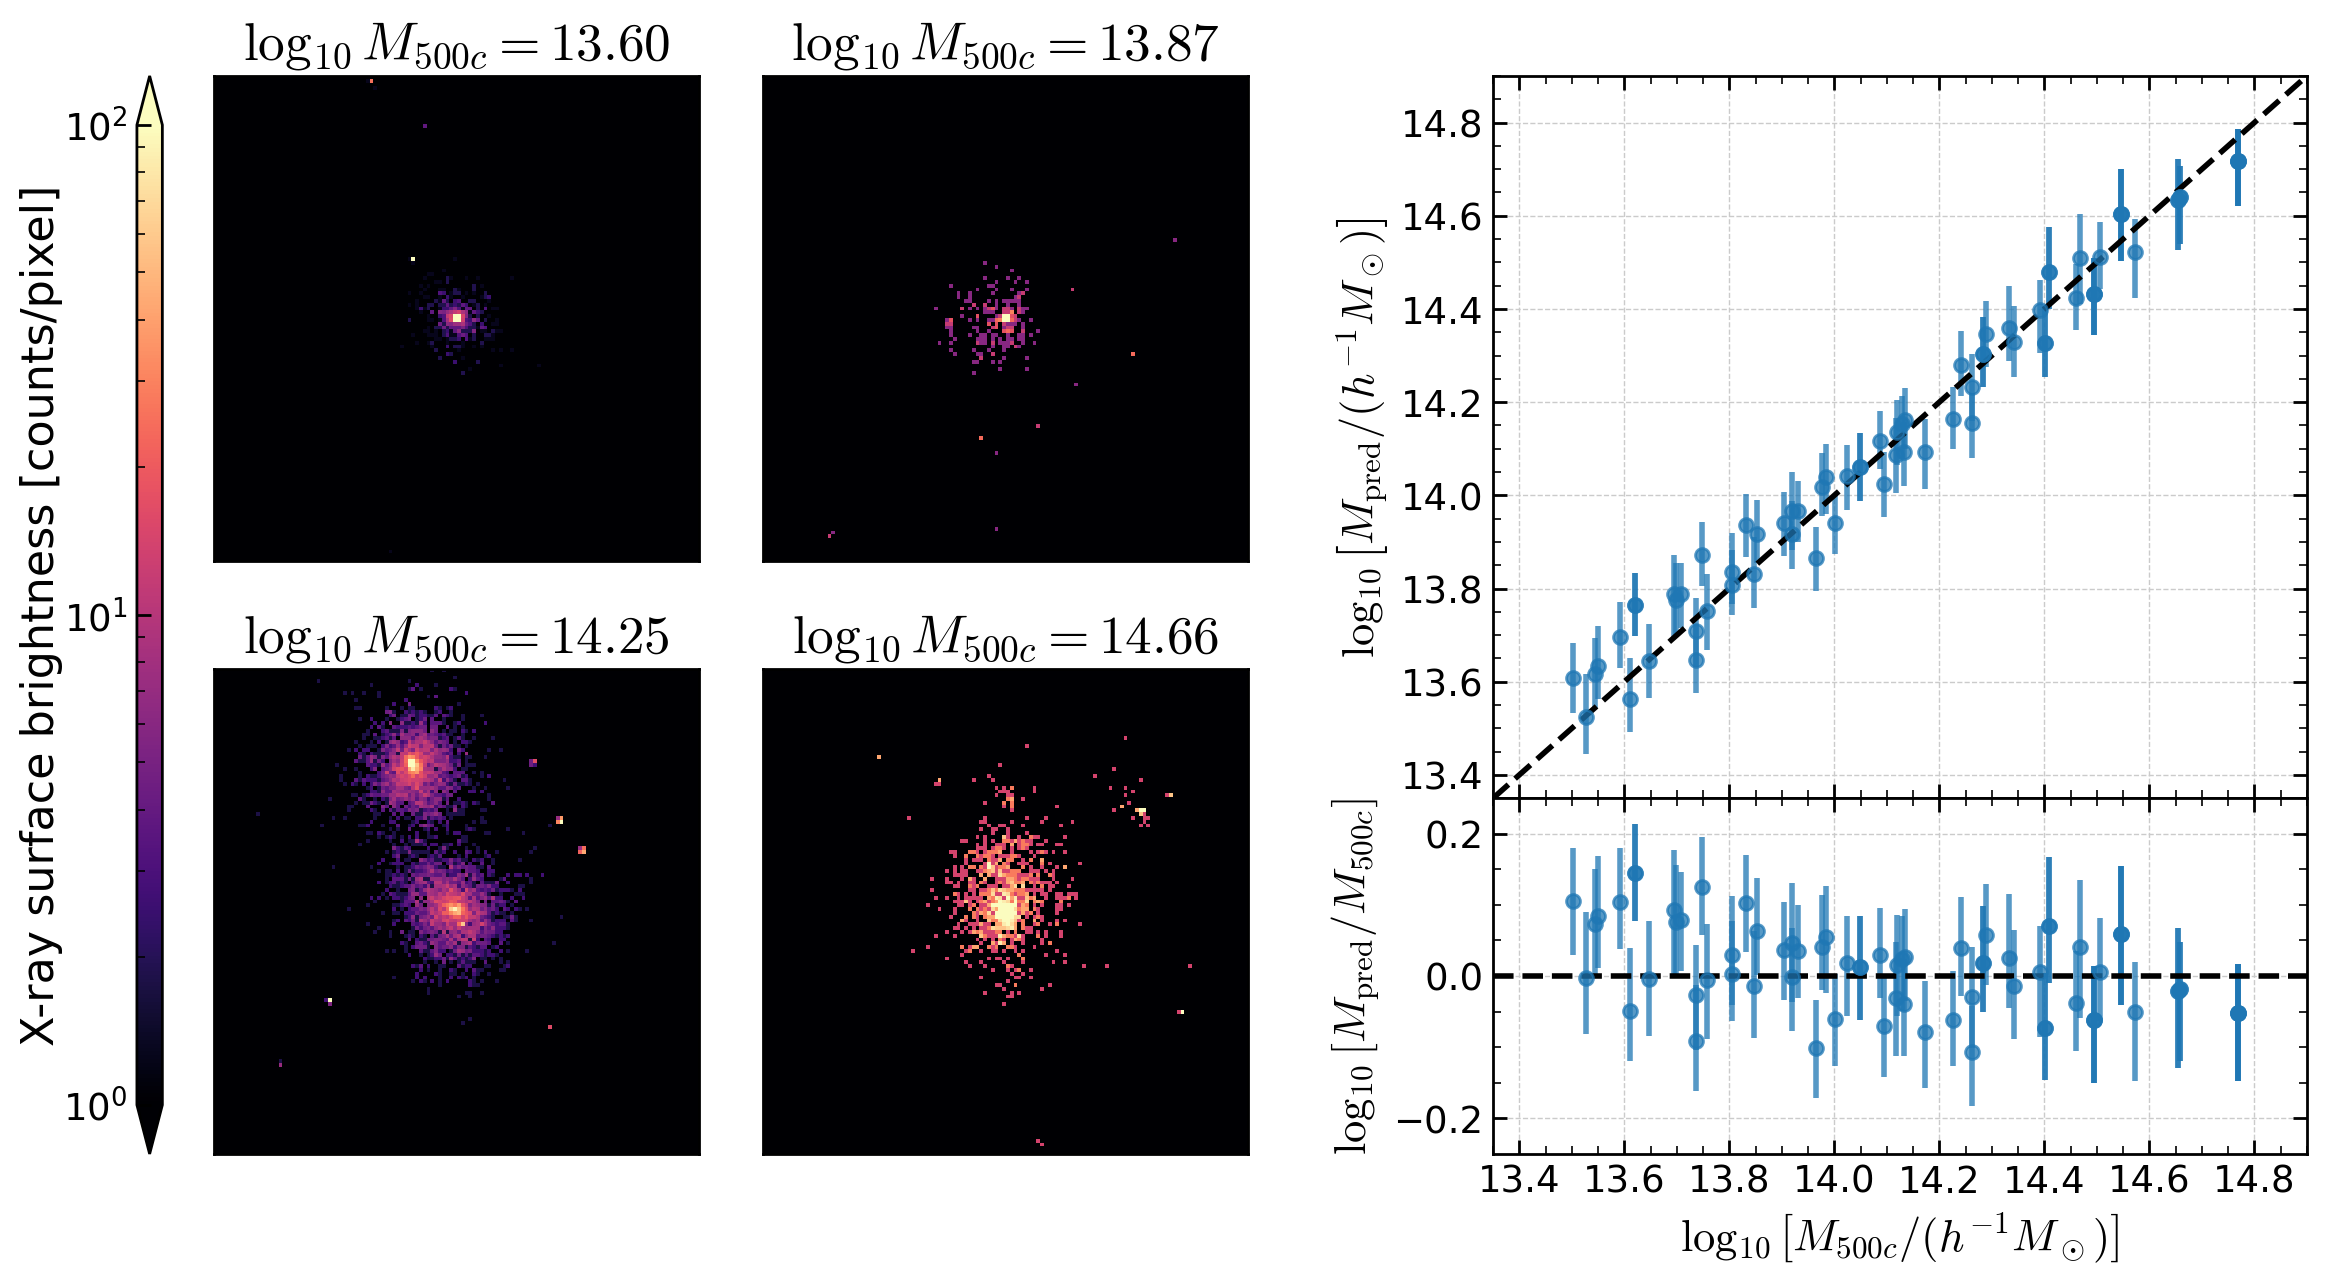

In [34]:
## Plot together

f = plt.figure(figsize=(14,7))
gs = mpl.gridspec.GridSpec(
    4, 5, 
    height_ratios=[0.45, 0.1, 0.12, 0.33],
    width_ratios=[0.05, 1, 1, 0.3, 1.6],
    wspace=0.1, hspace=0)

# plot examples
axes = [
    plt.subplot(gs[0, 1]), plt.subplot(gs[0, 2]), 
    plt.subplot(gs[2:, 1]), plt.subplot(gs[2:, 2])
]
for i, ax in zip(exinds, axes):
    x_ = 10**x[i] - 1
    im = ax.imshow(
        x_.T, cmap='magma', 
        norm=mpl.colors.LogNorm(vmin=1, vmax=100, clip=True))
    ax.set_title(f'$\log_{{10}} M_{{500c}} = {theta[i,0]:.2f}$')
    ax.set_xticks([])
    ax.set_yticks([])
cax = plt.subplot(gs[:, 0])
cbar = plt.colorbar(im, cax=cax, extend='both')
cbar.set_label('X-ray surface brightness [counts/pixel]', 
               rotation=90, labelpad=0)
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')

# plot errorbars
ax = plt.subplot(gs[0:3, 4])
ax.errorbar(
    theta[to_plot, 0], sperc[1,to_plot], 
    yerr=[sperc[1,to_plot]-sperc[0,to_plot], 
          sperc[2,to_plot]-sperc[1,to_plot]], 
    fmt='o', color='C0', label='SNPE posterior', ms=5,
    alpha=0.75)
x_ = [13.35,14.9]
ax.plot(x_, x_, color='k', label='True', ls='--')
ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/(h^{-1}M_\odot)\right]$')
ax.set_xlim(*x_)
ax.set_ylim(*x_)
ax.set_xticks(np.arange(13.4,15,0.2))
ax.set_xticklabels([])

ax = plt.subplot(gs[3, 4])
ax.errorbar(
    theta[to_plot, 0], sperc[1,to_plot]-theta[to_plot, 0], 
    yerr=[sperc[1,to_plot]-sperc[0,to_plot], 
          sperc[2,to_plot]-sperc[1,to_plot]], 
    fmt='o', color='C0', label='SNPE posterior', ms=5,
    alpha=0.75)
ax.plot(x_, [0,0], color='k', ls='--')
ax.set_xlabel(r'$\log_{10}\left[M_{500c}/(h^{-1}M_\odot)\right]$')
ax.set_ylabel(r'$\log_{10}\left[M_{\rm pred}/M_{500c}\right]$')
ax.set_ylim(-0.25, 0.25)
ax.set_xlim(*x_)
ax.set_xticks(np.arange(13.4,15,0.2))

f.savefig(join(imdir, 'xray_example_posterior.pdf'), bbox_inches='tight')

In [42]:
np.diff(x_)

array([1.55])